In [2]:
%matplotlib inline
import numpy as np
import lib.io.stan
import lib.syn_data
import matplotlib.pyplot as plt

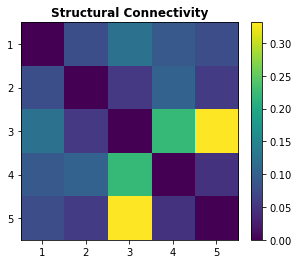

In [2]:
np.random.seed(0)
nn = 5
SC = lib.syn_data.gen_con(nn)
im = plt.imshow(SC)
plt.xticks(np.arange(0,nn),map(str,np.arange(1,nn+1)))
plt.yticks(np.arange(0,nn),map(str,np.arange(1,nn+1)))
plt.colorbar(fraction=0.046, pad=0.04)
plt.gca().set_title("Structural Connectivity",fontweight="bold")

np.savez('results/exp5/network.npz', SC=SC)

In [6]:
results_dir = 'results/exp5'
I1 = 3.1
tau0 = 30.0
sigma = 0.01
k = -2.0
Ic = np.zeros(nn)

x0 = -2.5*np.ones(nn)
x0[2] = -1.8
x0[4] = -2.2
time_scale = 1.0
time_step = 0.1
nt = 50*int(1/time_step)
sigma_xobs = 0.1
sigma_zobs = 0.1

x_init = -0.5*np.ones(nn)
z_init = 1.5*np.ones(nn)
z_eta = np.random.normal(0.0, 1.0, [nt-1, nn])

data = {'nn':nn, 'nt':nt, 'I1':I1, 'tau0':tau0, 'Ic':Ic, 'SC':SC, 
        'sigma':sigma, 'k':k, 'sigma_xobs':sigma_xobs,'sigma_zobs':sigma_zobs,        
        'x0':x0, 'time_scale':time_scale, 'time_step':time_step,
        'x_init':x_init, 'z_init':z_init, 'z_eta': z_eta}

lib.io.stan.rdump(f'{results_dir}/sim_data.R',data)

stan_fname = './vep-srcfit-sim'
lib.io.stan.create_process(['bash','/home/anirudhnihalani/scripts/stancompile.sh', stan_fname],block=True)
sim_cmd = stan_fname + f' sample algorithm=fixed_param num_samples=1 num_warmup=0 data \
file={results_dir}/sim_data.R output file={results_dir}/sim_out.csv'
lib.io.stan.create_process(sim_cmd.split(),block=True)

/home/anirudhnihalani/vep.stan
make: `/home/anirudhnihalani/vep.stan/./vep-srcfit-sim' is up to date.


make: Warning: File `/home/anirudhnihalani/vep.stan/./vep-srcfit-sim' has modification time 221 s in the future
make: warning:  Clock skew detected.  Your build may be incomplete.


Continue[y/n]:y
method = sample (Default)
  sample
    num_samples = 1
    num_warmup = 0
    save_warmup = 0 (Default)
    thin = 1 (Default)
    adapt
      engaged = 1 (Default)
      gamma = 0.050000000000000003 (Default)
      delta = 0.80000000000000004 (Default)
      kappa = 0.75 (Default)
      t0 = 10 (Default)
      init_buffer = 75 (Default)
      term_buffer = 50 (Default)
      window = 25 (Default)
    algorithm = fixed_param
id = 0 (Default)
data
  file = results/exp5/sim_data.R
init = 2 (Default)
random
  seed = 1848181070
output
  file = results/exp5/sim_out.csv
  diagnostic_file =  (Default)
  refresh = 100 (Default)

Iteration: 1 / 1 [100%]  (Sampling)

 Elapsed Time: 0 seconds (Warm-up)
               0.05 seconds (Sampling)
               0.05 seconds (Total)



0

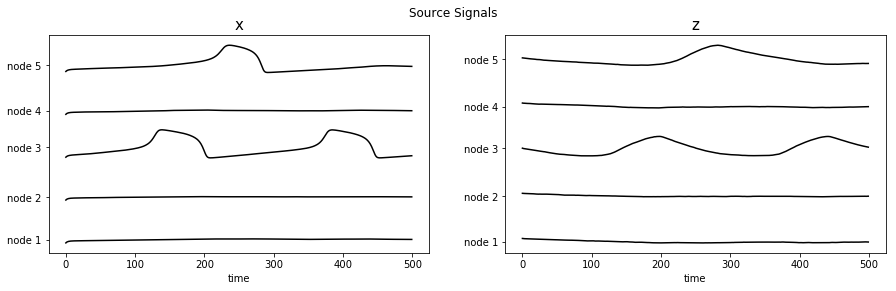

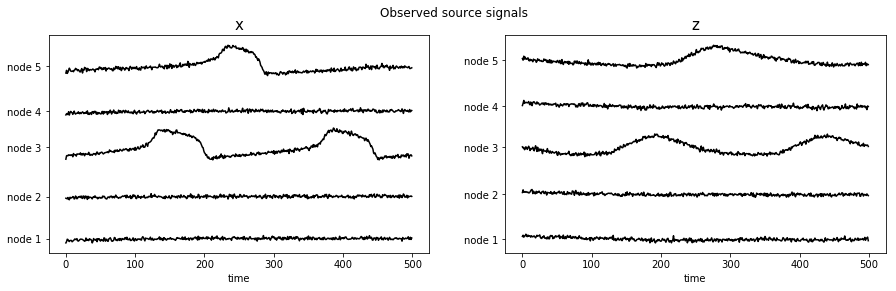

In [7]:
t = lib.io.stan.parse_csv(f'{results_dir}/sim_out.csv')
x = t['x'][0]
z = t['z'][0]
xobs = t['xobs'][0]
zobs = t['zobs'][0]


plt.figure(figsize=[15,4])
plt.subplot(121)
for i in range(nn):
    plt.plot(x.T[:,i]/4.0 + i,label=f'node{i+1}',color='black')
plt.yticks(np.mean(x.T/4.0 + np.arange(nn),axis=0), map(lambda x: f'node {x}',np.arange(1,nn+1)))
plt.xlabel('time')
plt.gca().set_title('x',fontsize=15.0)
plt.subplot(122)
for i in range(nn):
    plt.plot(z.T[:,i]/4.0 + i,label=f'node{i}',color='black')
plt.yticks(np.mean(z.T/4.0 + np.arange(nn),axis=0), map(lambda x: f'node {x}',np.arange(1,nn+1)))
plt.xlabel('time')
plt.gca().set_title('z',fontsize=15.0)
plt.suptitle('Source Signals')
plt.savefig(f'{results_dir}/figures/src_signals.png')


plt.figure(figsize=[15,4])
plt.subplot(121)
for i in range(nn):
    plt.plot(xobs.T[:,i]/4.0 + i,label=f'node{i+1}',color='black')
plt.yticks(np.mean(xobs.T/4.0 + np.arange(nn),axis=0), map(lambda x: f'node {x}',np.arange(1,nn+1)))
plt.xlabel('time')
plt.gca().set_title('x',fontsize=15.0)
plt.subplot(122)
for i in range(nn):
    plt.plot(zobs.T[:,i]/4.0 + i,label=f'node{i}',color='black')
plt.yticks(np.mean(zobs.T/4.0 + np.arange(nn),axis=0), map(lambda x: f'node {x}',np.arange(1,nn+1)))
plt.xlabel('time')
plt.gca().set_title('z',fontsize=15.0)
plt.suptitle('Observed source signals')
plt.savefig(f'{results_dir}/figures/obs_src_signals.png')

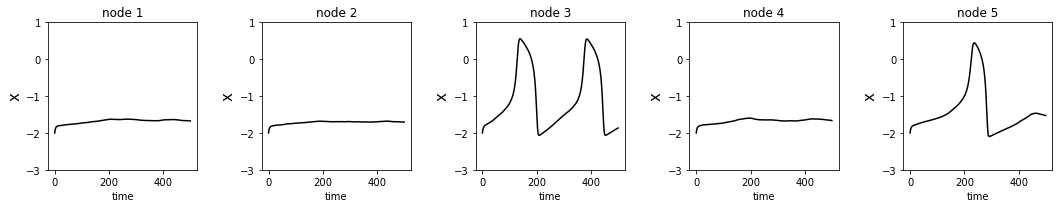

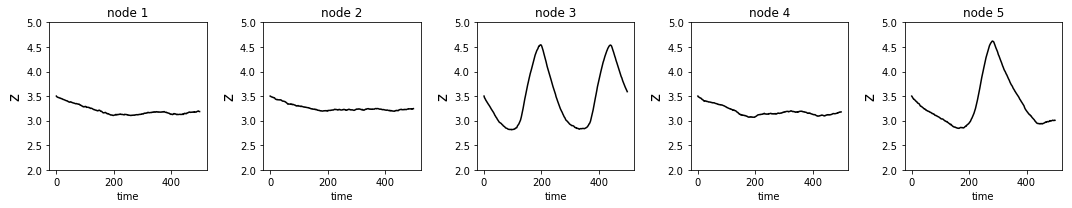

In [8]:
plt.figure(figsize=[15,3])
for i in range(nn):
    plt.subplot(1,5,i+1)
    plt.plot(x[i,:],'k')
    plt.xlabel('time')
    plt.ylabel('x',fontsize=15.0)
    plt.ylim([-3.0,1.0])
    plt.gca().set_title(f'node {i+1}')
plt.savefig(f'{results_dir}/figures/src_signals_2.png')    
    
plt.tight_layout()
plt.figure(figsize=[15,3])
for i in range(nn):
    plt.subplot(1,5,i+1)
    plt.plot(z[i,:],'k')
    plt.xlabel('time')
    plt.ylabel('z',fontsize=15.0)
    plt.ylim([2.0,5.0])
    plt.gca().set_title(f'node {i+1}')
plt.tight_layout()
plt.savefig(f'{results_dir}/figures/src_signals_3.png')

In [9]:
data = {'nn':nn, 'nt':nt, 'I1':I1, 'tau0':tau0, 'Ic':Ic, 'SC':SC, 
        'sigma':sigma, 'k':k, 'sigma_xobs':sigma_xobs,        
        'x0':x0, 'time_scale':time_scale, 'time_step':time_step,
        'x_init':x_init, 'z_init':z_init, 'z_eta': z_eta, 'xobs': xobs.T}

lib.io.stan.rdump(f'{results_dir}/fit_data.R',data)

stan_fname = './vep-srcfit'
lib.io.stan.create_process(['bash','/home/anirudhnihalani/scripts/stancompile.sh', stan_fname],block=True)

nchains = 8
with open('vep-srcfit.sh','r') as fd:
    slurm_script = fd.read().format(results_dir,nchains)
with open('tmp/vep-srcfit.sh','w') as fd:
    fd.write(slurm_script)
lib.io.stan.create_process(['sbatch','tmp/vep-srcfit.sh'],block=False)


/home/anirudhnihalani/vep.stan

--- Translating Stan model to C++ code ---
bin/stanc  /home/anirudhnihalani/vep.stan/./vep-srcfit.stan --o=/home/anirudhnihalani/vep.stan/./vep-srcfit.hpp
Model name=vep_srcfit_model
Input file=/home/anirudhnihalani/vep.stan/./vep-srcfit.stan
Output file=/home/anirudhnihalani/vep.stan/./vep-srcfit.hpp

--- Linking C++ model ---
g++ -Wall -I . -isystem stan/lib/stan_math/lib/eigen_3.3.3 -isystem stan/lib/stan_math/lib/boost_1.64.0 -isystem stan/lib/stan_math/lib/cvodes_2.9.0/include -std=c++1y -DBOOST_RESULT_OF_USE_TR1 -DBOOST_NO_DECLTYPE -DBOOST_DISABLE_ASSERTS -DBOOST_PHOENIX_NO_VARIADIC_EXPRESSION -I src -I stan/src -isystem stan/lib/stan_math/ -DEIGEN_NO_DEBUG -DFUSION_MAX_VECTOR_SIZE=12 -DNO_FPRINTF_OUTPUT -pipe -lpthread  -O3 -o /home/anirudhnihalani/vep.stan/./vep-srcfit src/cmdstan/main.cpp -include /home/anirudhnihalani/vep.stan/./vep-srcfit.hpp stan/lib/stan_math/lib/cvodes_2.9.0/lib/libsundials_nvecserial.a stan/lib/stan_math/lib/cvodes_2.9.0/l

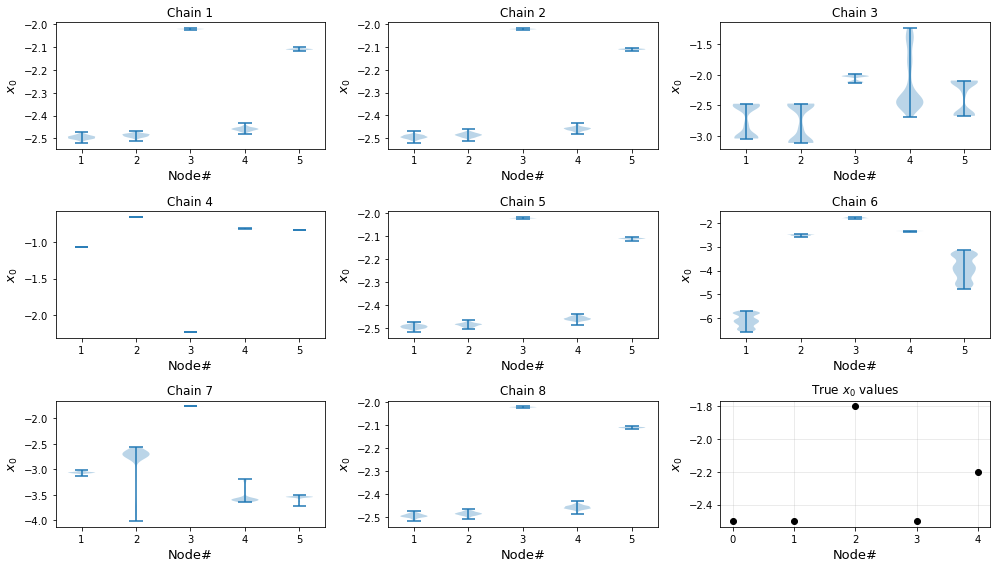

In [15]:
chains = [1,2,3,4,5,6,7,8]
plt.figure(figsize=[14,8])
j = 0
for i in chains:
    j = j + 1
    t = lib.io.stan.parse_csv(f'{results_dir}/samples_chain{i}.csv')    
    plt.subplot(3,3,j)
    plt.violinplot(t['x0'][200:,:])
#     plt.ylim([-3.5,-0.5])
    plt.xlabel('Node#',fontsize=13)
    plt.ylabel('$x_0$',fontsize=13)
    plt.gca().set_title(f'Chain {i}')

plt.subplot(3,3,9)
plt.plot(x0,'ko')
# plt.ylim([-3.5,-0.5])
plt.grid(alpha=0.3)
plt.xlabel('Node#',fontsize=13)
plt.ylabel('$x_0$',fontsize=13)
plt.gca().set_title('True $x_0$ values')
plt.tight_layout() 
plt.savefig(f'{results_dir}/figures/posterior_violins.png')

Compute the predictive distrubtion

In [42]:
chains = [1,2,3,4,5,6,7,8]
sim_data = lib.io.stan.rload(f'{results_dir}/sim_data.R')
for i in chains:
    t = lib.io.stan.parse_csv(f'{results_dir}/samples_chain{i}.csv')
    x0_samples = t['x0'][200:,:]
    x_pred_dist = np.zeros([np.size(x0_samples, 0),
                           sim_data['nn'],sim_data['nt']]) # Predictive distribution of x for chain i
    j = 0
    for j,x0 in enumerate(x0_samples):
        data = sim_data
        data['x0'] = x0
        lib.io.stan.rdump('tmp/sim_data.R',data)
        sim_cmd = f'./vep-srcfit-sim sample algorithm=fixed_param num_samples=1 num_warmup=0 data \
        file=tmp/sim_data.R output file=tmp/sim_out.csv'
        lib.io.stan.create_process(sim_cmd.split(),block=True,stdout=open('/dev/null','ab'))
        t = lib.io.stan.parse_csv('tmp/sim_out.csv')
        x_pred_dist[j,:,:] = t['xobs'][0]
    np.save(f'{results_dir}/pred_dist_chain{i}.npy',x_pred_dist)

plots of predictive distribution of each chain, bold lines are mean and shaded region is 1 standard deviation above and below the mean

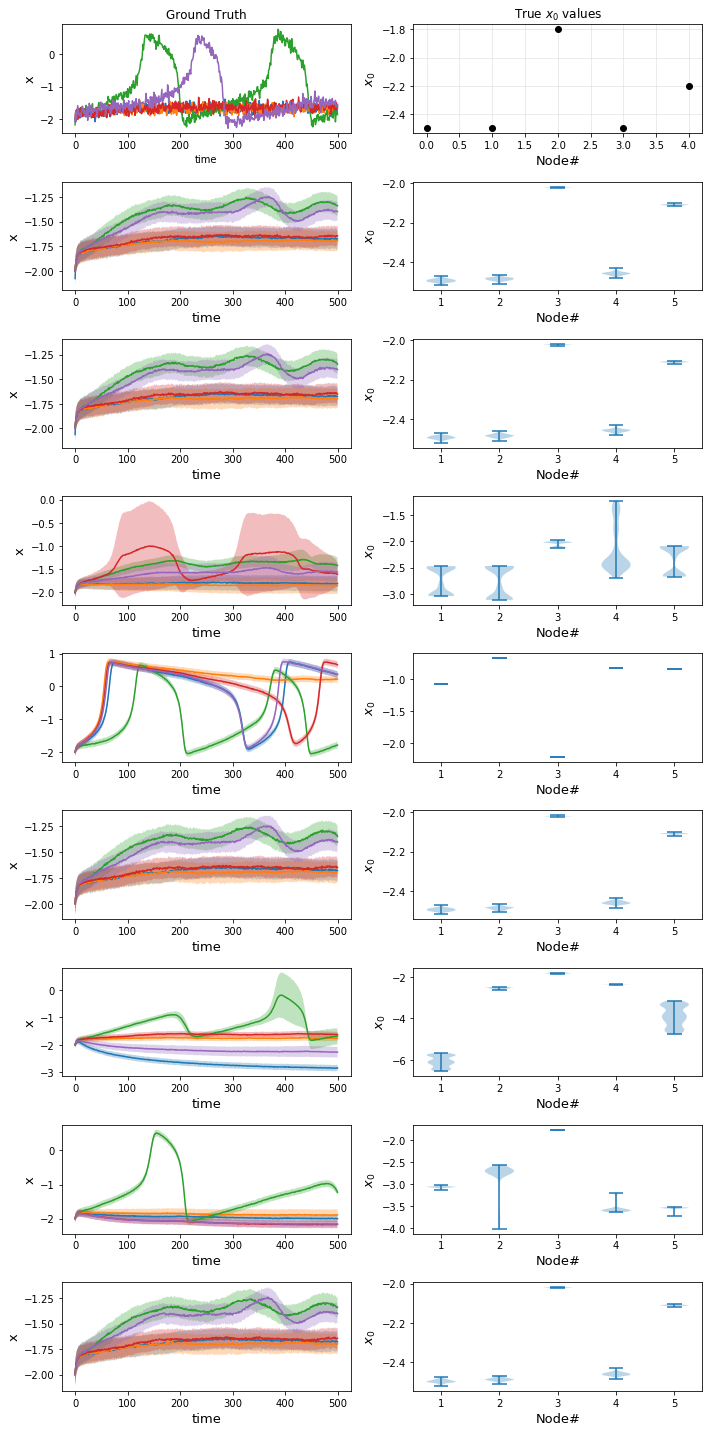

In [38]:
results_dir = 'results/exp5'
t = lib.io.stan.parse_csv(f'{results_dir}/sim_out.csv')
x_true = t['xobs'][0].T
t = lib.io.stan.rload(f'{results_dir}/sim_data.R')
x0_true = t['x0']
chains = [1,2,3,4,5,6,7,8]
plt.figure(figsize=[10,20])
plt.subplot(len(chains)+1,2,1)
plt.plot(x_true)
plt.xlabel('time')
plt.ylabel('x',fontsize=13.0)
plt.gca().set_title('Ground Truth')
plt.subplot(len(chains)+1,2,2)
plt.plot(x0_true,'ko')
# plt.ylim([-3.5,-0.5])
plt.grid(alpha=0.3)
plt.xlabel('Node#',fontsize=13)
plt.ylabel('$x_0$',fontsize=13)
plt.gca().set_title('True $x_0$ values')

for i in chains:
    x_pred_dist = np.load(f'{results_dir}/pred_dist_chain{i}.npy')
    x_pred_mean = np.mean(x_pred_dist,axis=0).T
    x_pred_sd = np.std(x_pred_dist,axis=0).T
    plt.subplot(len(chains)+1, 2, 2*i+1)
    plt.plot(x_pred_mean)
    ub = x_pred_mean + x_pred_sd
    lb = x_pred_mean - x_pred_sd
    for j in range(x_pred_mean.shape[1]):
        plt.fill_between(range(x_pred_mean.shape[0]), ub[:,j], lb[:,j], alpha=0.3)
    plt.xlabel('time', fontsize=13.0)
    plt.ylabel('x', fontsize=13.0)

    t = lib.io.stan.parse_csv(f'{results_dir}/samples_chain{i}.csv')    
    plt.subplot(len(chains)+1, 2, 2*i + 2)
    plt.violinplot(t['x0'][200:,:])
#     plt.ylim([-3.5,-0.5])
    plt.xlabel('Node#',fontsize=13)
    plt.ylabel('$x_0$',fontsize=13)
plt.tight_layout()    